# Before running this notebook:

Using your own machine or ideally a virtual machine with many cores, open the `parallelizing.py` [script to parallel-compute the Stockfish scores for all of the games](./parallelizing.py).  Follow the instructions written in the comments at the top of that script; you will have to edit indicated parameters.  Run the script on your (vitrual) machine.  (Our project used a virtual machine with 94 cores and this step took a little over 24 hours.)

This script uses Stockfish to evaluate all of the positions achieved in all of the games in our training, test, and validation data sets of first games played by new players.  For each game, it also has Stockfish compute the "top 10 moves" for the new player on each of that player's turns.  Finally, for each individual game, it saves a `.txt` file representing a dictionary containing these pieces of information from that game (along with the FEN strings representing the positions achieved in that game).  For example, the file `game123.txt` in the `data/sf_evals/train` folder contains all the information from the game in the 123rd row of the `train_1st.csv` dataset produced in the [last notebook](./02_data_preparing.ipynb).

# Summary of this notebook

In this notebook, we read in the `.txt` files containing the information that Stockfish computed about each of the games in our `train_1st.csv`, `test_1st.csv` and `val_1st.csv` datasets of first games of the new players.  We verify that the board positions referenced in these `.txt` files match those in the games to which they are supposed to correspond.  Then, for each of the training, test, and validation data kinds, we combine the evaluations-of-new-players'-moves-in-their-first-games data from the `.txt` files with the non-move-related data in the other datasets, outputting a single dictionary (stored as a text file).

For example, we combine the `.txt` files in the `train` folder with the information in `train_1st.csv`, `train_2nd.csv` and `train_opp.csv` to create a single file `train.txt` (and a less memory-intensive pickled file `train.pcl`) that contains all the information we will use in modeling the outcome of the new players' 2nd games.  We do similarly for the test and validation data.

In [77]:
import pandas as pd
import numpy as np

import chess
from stockfish import Stockfish

import pickle

In [2]:
# CHANGE THIS CELL TO POINT TO THE STOCKFISH APP INSTALLED ON YOUR MACHINE
stockfish_path = '/opt/homebrew/bin/stockfish'

# Read in the games

## Read in the CSVs without the Stockfish evaluations

In [3]:
train_1st = pd.read_csv('../data/processed/train/train_1st.csv', index_col='name_of_pl_playing_1st_game')
test_1st = pd.read_csv('../data/processed/test/test_1st.csv', index_col='name_of_pl_playing_1st_game')
val_1st = pd.read_csv('../data/processed/val/val_1st.csv', index_col='name_of_pl_playing_1st_game')

train_2nd = pd.read_csv('../data/processed/train/train_2nd.csv', index_col='name_of_pl_playing_2nd_game')
test_2nd = pd.read_csv('../data/processed/test/test_2nd.csv', index_col='name_of_pl_playing_2nd_game')
val_2nd = pd.read_csv('../data/processed/val/val_2nd.csv', index_col='name_of_pl_playing_2nd_game')

train_opp = pd.read_csv('../data/processed/train/train_opp.csv', index_col='new_pl_to_be_played_next_game')
test_opp = pd.read_csv('../data/processed/test/test_opp.csv', index_col='new_pl_to_be_played_next_game')
val_opp = pd.read_csv('../data/processed/val/val_opp.csv', index_col='new_pl_to_be_played_next_game')

#### Look at the first rows of some of these

In [4]:
test_1st.head(1)

,opponent,new_pl_color,new_pl_won,new_pl_elo,opp_elo,new_pl_rating_diff,opp_rating_diff,game_length,time_limit,time_gain_per_move,event,termination,conceded,datetime,timestamp,moves,both_players_1st_game
name_of_pl_playing_1st_game,,,,,,,,,,,,,,,,,
SsAaRrAa,sanchetta,White,1.0,1500.0,1498.0,177.0,-8.0,32,1500.0,0.0,Classical,Normal,1,2016-07-05 17:24:10,1.467739e+09,e4 g5 d4 e6 Nf3 Bh6 Nc3 d6 Bc4 e5 d5 g4 Nd2 Nf...,0


In [5]:
val_2nd.head(1)

,opponent,new_pl_color,new_pl_won,new_pl_elo,opp_elo,new_pl_rating_diff,opp_rating_diff,game_length,time_limit,time_gain_per_move,event,termination,conceded,datetime,timestamp,moves,both_players_2nd_game
name_of_pl_playing_2nd_game,,,,,,,,,,,,,,,,,
noobstyle,puffknuckle,Black,1.0,1672.0,1633.0,105.0,-8.0,22,600.0,0.0,Classical,Normal,0,2016-07-26 19:20:59,1.469561e+09,e4 e5 d3 Nc6 Ne2 d5 exd5 Qxd5 c4 Qa5+ Bd2 Qb6 ...,0


In [6]:
train_opp.head(1)

,opp_of_new_pl,opp_of_opp,opp_color,opp_won,opp_elo,opp_opp_elo,opp_rating_diff,opp_opp_rating_diff,game_length,time_limit,time_gain_per_move,event,termination,conceded,datetime,timestamp,moves,both_users_to_play_new_pl_next,2nd_game_opp_had_no_previous_game
new_pl_to_be_played_next_game,,,,,,,,,,,,,,,,,,,
SAKATBIRAKAN,kami1946,TD9174,Black,0.0,1612.0,1882.0,-4.0,4.0,55,300.0,4.0,Blitz,Normal,1,2016-07-13 19:56:06,1.468440e+09,e4 b6 d4 Bb7 d5 c5 c4 d6 Bd3 Nf6 Nc3 Bc8 h3 Nb...,0,0


## Read a single game's Stockfish evaluations from a text file

In [7]:
#Dictionary of dataframes without Stockfish evaluations
dfs_dict = {
   'train':train_1st,
    'test':test_1st,
     'val':val_1st
}

#Dictionary of paths to text files with stockfish evaluations
stockfish_paths_dict = {
   'train':'../data/sf_evals/train',
    'test':'../data/sf_evals/test',
     'val':'../data/sf_evals/val'
}

In [8]:
#Read a single game's Stockfish evaluations as a dictionary
example_game_number = 1234
example_kind = 'train'
example_game = eval(open(f"{stockfish_paths_dict[example_kind]}/game{example_game_number}.txt").read())

In [9]:
#Look at the first move
example_game[0]

{'eval': {'type': 'cp', 'value': 64},
 'fen': 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'}

In [10]:
#Look at the second move
example_game[1]

{'eval': {'type': 'cp', 'value': 45},
 'fen': 'rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1',
 'top_10': [{'Move': 'c7c5', 'Centipawn': 40, 'Mate': None},
  {'Move': 'e7e5', 'Centipawn': 56, 'Mate': None},
  {'Move': 'e7e6', 'Centipawn': 59, 'Mate': None},
  {'Move': 'b8c6', 'Centipawn': 70, 'Mate': None},
  {'Move': 'd7d6', 'Centipawn': 83, 'Mate': None},
  {'Move': 'd7d5', 'Centipawn': 85, 'Mate': None},
  {'Move': 'c7c6', 'Centipawn': 89, 'Mate': None},
  {'Move': 'h7h6', 'Centipawn': 91, 'Mate': None},
  {'Move': 'a7a6', 'Centipawn': 94, 'Mate': None},
  {'Move': 'h7h5', 'Centipawn': 132, 'Mate': None}]}

As we can see, this example game is one where the new player is playing Black: our script only recorded the "top 10 moves" for each of the *new player's* turns.  Let's verify that this is correct, though:

### Match the Stockfish evaluations to the new player whose game they came from

In [11]:
#Find the row whose number is the same as the number in the imported text file's name
dfs_dict[example_kind].iloc[[example_game_number]]

,opponent,new_pl_color,new_pl_won,new_pl_elo,opp_elo,new_pl_rating_diff,opp_rating_diff,game_length,time_limit,time_gain_per_move,event,termination,conceded,datetime,timestamp,moves,both_players_1st_game
name_of_pl_playing_1st_game,,,,,,,,,,,,,,,,,
boedoet10,Nanas,Black,0.0,1500.0,1908.0,-48.0,4.0,105,300.0,0.0,Blitz,Time forfeit,1,2016-07-16 05:32:47,1.468647e+09,e4 e5 Bc4 c6 Qe2 d5 exd5 cxd5 Qxe5+ Be6 Bb5+ N...,0


As we can see, this new player was indeed playing Black.  Furthermore, let's verify that all the moves made in this game result in the same positions as recorded in the imported dictionary (in the form of FEN strings):

In [12]:
def check_same_moves(game_number, kind):
    '''
    Input:
    -game_number: The number of a text file containing a dictionary of Stockfish evaluations
    for a single game
    -kind: A string 'train', 'test' or 'val'
    
    Checks if this text file does indeed correspond to the game in row game_number of the
    dataframe of the specified kind.
    The check is made by going through all the moves and checking that the resulting
    positions' FEN strings are the same as those in the dictionary.
    Returns True if everything matches up; returns False otherwise.
    '''
    #Read in the text file as a dictionary
    game = eval(open(f"{stockfish_paths_dict[kind]}/game{game_number}.txt").read())
    
    #Select the correct dataframe
    df = dfs_dict[kind]
    
    #Make a list of the moves in the game
    moves = df.iloc[game_number]['moves'].split(' ')
    
    #Initialize a chess Board
    board = chess.Board()
    
    #Check if the initial board position is the same as the one recorded in the dictionary
    same = (board.fen() == game[0]['fen'])
    
    for i, move in enumerate(moves):
        #If you've just encountered a position that is not the same as the one
        #recorded in the dictionary, then stop checking
        if not same:
            break
        
        #Otherwise, make the next move...
        board.push_san(move)
        position = board.fen()
        #... and check if the position matches the one in the dictionary after this move
        same = (position == game[i+1]['fen'])
    
    #This should be True if all positions achieved in the game are the same as those
    #that appear in the dictionary
    return same

In [13]:
#Check that our example game matches the corresponding row of our train_1st dataframe
check_same_moves(game_number = example_game_number, kind = example_kind)

True

# Check that all games' text files match the rows of our dataframe

In [14]:
def all_games_match(kind):
    '''
    Input: A string 'train', 'test' or 'val'
    
    Checks if all positions match up between the text files of Stockfish evaluations
    and the corresponding dataframe.
    '''
    
    #Get the correct dataframe
    df = dfs_dict[kind]
    
    #Loop over the games in the dataframe and check that they match the text files
    for i in range(len(df)):
        is_same = check_same_moves(game_number = i, kind = kind)
        
        #If you ever encounter a non-matching game, break out of the loop
        if not is_same:
            break
    
    #Return the result
    return is_same
    

In [15]:
matches = []
for kind in ['train', 'test', 'val']:
    matches.append(all_games_match(kind))

In [16]:
#Did all the train, test, and val games match?
matches

[True, True, True]

Since all three are `True`, we know that all of the rows of our dataframes properly correspond to the text files we have.

# Combine the data from the `.txt` files with that in the 1st-games, 2nd-games, and opponents'-games datasets

In [17]:
dfs_dict = {
   'train_1st':train_1st,
    'test_1st':test_1st,
     'val_1st':val_1st,
    'train_2nd':train_2nd,
    'test_2nd':test_2nd,
     'val_2nd':val_2nd,
    'train_opp':train_opp,
    'test_opp':test_opp,
     'val_opp':val_opp,
}

We will combine all of these data into a dictionary containing all of the information that our models will use to predict the outcome of a new player's 2nd game.

To illustrate our method, we'll extract all the information for a single player from the training data.

In [18]:
#Choose a game to use
game_number = 123
kind = 'train'

## Get information from the new player's 1st game

In [19]:
#Find the row whose number is the same as the number in the imported text file's name
dfs_dict[f"{kind}_1st"].iloc[[game_number]]

,opponent,new_pl_color,new_pl_won,new_pl_elo,opp_elo,new_pl_rating_diff,opp_rating_diff,game_length,time_limit,time_gain_per_move,event,termination,conceded,datetime,timestamp,moves,both_players_1st_game
name_of_pl_playing_1st_game,,,,,,,,,,,,,,,,,
The_Mechanic_Arg,valter48,White,0.0,1500.0,1801.0,-71.0,4.0,70,600.0,0.0,Classical,Normal,1,2016-07-13 12:58:33,1.468415e+09,e3 e5 d3 d5 Nc3 Nf6 Nf3 Bd6 d4 e4 b3 exf3 Qxf3...,0


We won't use the `opponent` column, as the opponent's name is not something we want our models to use.  We won't use `new_pl_elo` for the *first game* since it's always 1500 in this game.  We also won't use `event` since the labels Classical, Blitz and Bullet simply correspond to different ranges of the `time_limit` variable (which we *will* be using).  We also won't use the `datetime` and `timestamp` columns, as we don't want our models learning from these.  Finally, we won't use the `moves` variable since this information will be included from the `.txt` files and not from the dataframes.

Thus, we will use the following columns of information:

In [20]:
# Make a list of the columns we're going to use for modeling
cols_1st = [
    'new_pl_color', 'new_pl_won', 'opp_elo', 'new_pl_rating_diff', 'opp_rating_diff',
    'game_length', 'time_limit', 'time_gain_per_move', 'termination', 'conceded',
    'both_players_1st_game'
]

The `termination` column contains categorical values; these need to be converted into integers to feed into our models.  What are all the values that it takes on?

In [21]:
train_1st['termination'].value_counts()

Normal              15556
Time forfeit         4858
Rules infraction        6
Name: termination, dtype: int64

As we can see, the "Rules infraction" value occurs extremely rarely, so our model will not be able to learn much from it.  We'll just map the "Rules infraction" cases to the same value as "Normal" since, with so few instances, it doesn't really matter whether we group them with "Normal" or "Time Forfeit" games.

In [22]:
#Make a dictionary for how to convert the strings in the "termination" column into ints
termination_dict = {
    'Normal':0,
    'Time forfeit':1,
    'Rules infraction':0
}

#Also make a dictionary to convert the colors to ints
color_dict = {
 'White':0,   
 'Black':1
}

In [23]:
#Initialize a dictionary to contain the information we're extracting
example_dict = {}

In [24]:
#Get the new player's name
new_pl_name = dfs_dict[f"{kind}_1st"].iloc[[game_number]].index[0]

#Add some placeholders to our dictionary for this player
example_dict[new_pl_name] = {}
example_dict[new_pl_name]['data'] = []

In [25]:
#Get the information that our models will use, from the new player's 1st game
row = dfs_dict[f"{kind}_1st"].iloc[game_number]

#Extract the information from the columns we'll use
for col in cols_1st:
    #The "termination" column contains a string; convert it to an int
    if col == 'termination':
        example_dict[new_pl_name]['data'].append(termination_dict[row[col]])
        
    #The "new_pl_color" column contains a string; convert it to an int
    elif col == 'new_pl_color':
        example_dict[new_pl_name]['data'].append(color_dict[row[col]])
        
    #Otherwise, just extract the information
    else:
        example_dict[new_pl_name]['data'].append(row[col])
    
#Get the color that the new player played in her first game
new_pl_1st_game_color = row['new_pl_color']

In [26]:
example_dict

{'The_Mechanic_Arg': {'data': [0,
   0.0,
   1801.0,
   -71.0,
   4.0,
   70,
   600.0,
   0.0,
   0,
   1,
   0]}}

## Get information from the new player's 2nd game

In [27]:
dfs_dict[f"{kind}_2nd"].loc[[new_pl_name]]

,opponent,new_pl_color,new_pl_won,new_pl_elo,opp_elo,new_pl_rating_diff,opp_rating_diff,game_length,time_limit,time_gain_per_move,event,termination,conceded,datetime,timestamp,moves,both_players_2nd_game
name_of_pl_playing_2nd_game,,,,,,,,,,,,,,,,,
The_Mechanic_Arg,flashb4nged,White,1.0,1429.0,1435.0,141.0,-8.0,61,600.0,0.0,Classical,Normal,1,2016-07-13 18:40:15,1.468435e+09,e3 e5 Nf3 Nc6 d4 exd4 exd4 d5 Nc3 Nf6 Bb5 a6 B...,0


We are trying to *predict the outcome of each new player's 2nd game*.  Thus, we can only use a limited amount of information about this second game without "cheating".  For example, our target variable is `new_pl_won` here; we certainly cannot include it as a feature.  We similarly cannot include `new_pl_rating_diff` or `opp_rating_diff`, as the signs of these numbers correspond to whether the new player won or lost.

Essentially, we can't use any information that *isn't available prior to the beginning of the new player's 2nd game*.  This means we can't include `game_length` as a feature, and we also can't include `new_pl_color` as a feature (since it isn't determined until the start of the game).

However, we *can* include the following variables as features, since they are *known at the time when matches are being made*:
- `new_pl_elo`
- `opp_elo`
- `time_limit`
- `time_gain_per_move`
- `both_players_2nd_game`

Similarly to what we did for the new players' first games, we also won't use the variables `opponent`, `event`, `datetime` or `timestamp`.

In [28]:
# Make a list of the columns we're going to use for modeling
cols_2nd = [
    'new_pl_elo', 'opp_elo', 'time_limit', 'time_gain_per_move', 'both_players_2nd_game'
]

In [29]:
#Get the information that our models will use, from the new player's 2nd game
row = dfs_dict[f"{kind}_2nd"].loc[new_pl_name]

#Extract the information from the columns we'll use
for col in cols_2nd:
    example_dict[new_pl_name]['data'].append(row[col])
    

#Extract the target variable as well
example_dict[new_pl_name]['target'] = row['new_pl_won']

In [30]:
#The "data" list should now have the information from the new player's 2nd game at its end.
#The "target" value should be whether the new player won her 2nd game or not.
example_dict

{'The_Mechanic_Arg': {'data': [0,
   0.0,
   1801.0,
   -71.0,
   4.0,
   70,
   600.0,
   0.0,
   0,
   1,
   0,
   1429.0,
   1435.0,
   600.0,
   0.0,
   0],
  'target': 1.0}}

## Get information from the new player's 2nd-game opponent's previous game

In [31]:
dfs_dict[f"{kind}_opp"].loc[[new_pl_name]]

,opp_of_new_pl,opp_of_opp,opp_color,opp_won,opp_elo,opp_opp_elo,opp_rating_diff,opp_opp_rating_diff,game_length,time_limit,time_gain_per_move,event,termination,conceded,datetime,timestamp,moves,both_users_to_play_new_pl_next,2nd_game_opp_had_no_previous_game
new_pl_to_be_played_next_game,,,,,,,,,,,,,,,,,,,
The_Mechanic_Arg,flashb4nged,gza09,Black,0.0,1445.0,1458.0,-10.0,11.0,27,600.0,0.0,Classical,Normal,1,2016-07-13 14:58:04,1.468422e+09,d4 d5 Nc3 c5 dxc5 e5 b4 d4 Ne4 Nc6 Rb1 Nf6 Bg5...,0,0


We will extract similar information from this game as we extracted from the new player's first game.  However, we must recall that some of the new players' 2nd-game opponents *did not play any game this month prior to facing the new player in her 2nd game*.  For these new players, the indicator variable `2nd_game_opp_had_no_previous_game` will equal 1 and most of the values in the row above will be missing; for all other players, this indicator variable will equal 0 and none of the information will be missing.

Thus, when adding information about the new player's 2nd-game opponent's previous game, we may need to impute reasonable values for the variables (if `2nd_game_opp_had_no_previous_game` equals 1).

In [32]:
# Make a list of the columns we're going to use for modeling
cols_opp = [
    'opp_color', 'opp_won', 'opp_elo', 'opp_opp_elo', 'opp_rating_diff', 'opp_opp_rating_diff',
    'game_length', 'time_limit', 'time_gain_per_move', 'termination', 'conceded',
    'both_users_to_play_new_pl_next', '2nd_game_opp_had_no_previous_game'
]

### Aside: Imputing missing values

In [33]:
#Find the mean rating of 2nd-game opponents of new players (in their previous game)
#Use the mean among the TRAINING data, so as to avoid data leakage
opp_mean_elo = round(train_opp['opp_elo'].mean(), 2)

#Do similarly for these opponents' opponents' ratings
opp_opp_mean_elo = round(train_opp['opp_opp_elo'].mean(), 2)

#Also get the mean game length and time controls
opp_mean_game_length = round(train_opp['game_length'].mean(), 2)
opp_mean_time_limit = round(train_opp['time_limit'].mean(), 2)
opp_mean_time_gain = round(train_opp['time_gain_per_move'].mean(), 2)

opp_mean_elo, opp_opp_mean_elo, opp_mean_game_length, opp_mean_time_limit, opp_mean_time_gain

(1578.62, 1566.93, 61.4, 572.01, 2.8)

In [34]:
# Make a dictionary of default values to use in case the 2nd-game opponent had no previous game
opp_defaults = {
    'opp_color':0,    #0 means "White"
    'opp_won':0.5,    #This is how we encode a "draw"
    'opp_elo':opp_mean_elo,
    'opp_opp_elo':opp_opp_mean_elo,
    'opp_rating_diff':0,
    'opp_opp_rating_diff':0,
    'game_length':opp_mean_game_length,
    'time_limit':opp_mean_time_limit,
    'time_gain_per_move':opp_mean_time_gain,
    'termination':0,   #0 means "Normal"
    'conceded':1,      #Since a "draw" can never be conceded, this is another way to distinguish these "fake" games
    'both_users_to_play_new_pl_next':0,
    '2nd_game_opp_had_no_previous_game':1
}

### Extract the information

In [35]:
#Get the information that our models will use, from the new player's 2nd-game opponent's previous game
row = dfs_dict[f"{kind}_opp"].loc[new_pl_name]

#If the new player's 2nd-game opponent had no previous game, use the default values
if row['2nd_game_opp_had_no_previous_game'] == 1:
    for col in cols_opp:
        example_dict[new_pl_name]['data'].append(opp_defaults[col])

#Otherwise, extract the information from the dataframe
else:
    for col in cols_opp:
        #The "termination" column contains a string; convert it to an int
        if col == 'termination':
            example_dict[new_pl_name]['data'].append(termination_dict[row[col]])
        
        #The "new_pl_color" column contains a string; convert it to an int
        elif col == 'opp_color':
            example_dict[new_pl_name]['data'].append(color_dict[row[col]])
        
        #Otherwise, just extract the information
        else:
            example_dict[new_pl_name]['data'].append(row[col])

In [36]:
#The "data" list should now have the information from the new player's 2nd-game opponent's
#previous game at the end.
example_dict

{'The_Mechanic_Arg': {'data': [0,
   0.0,
   1801.0,
   -71.0,
   4.0,
   70,
   600.0,
   0.0,
   0,
   1,
   0,
   1429.0,
   1435.0,
   600.0,
   0.0,
   0,
   1,
   0.0,
   1445.0,
   1458.0,
   -10.0,
   11.0,
   27,
   600.0,
   0.0,
   0,
   1,
   0,
   0],
  'target': 1.0}}

In [37]:
dfs_dict[f"{kind}_opp"].loc[[new_pl_name]]

,opp_of_new_pl,opp_of_opp,opp_color,opp_won,opp_elo,opp_opp_elo,opp_rating_diff,opp_opp_rating_diff,game_length,time_limit,time_gain_per_move,event,termination,conceded,datetime,timestamp,moves,both_users_to_play_new_pl_next,2nd_game_opp_had_no_previous_game
new_pl_to_be_played_next_game,,,,,,,,,,,,,,,,,,,
The_Mechanic_Arg,flashb4nged,gza09,Black,0.0,1445.0,1458.0,-10.0,11.0,27,600.0,0.0,Classical,Normal,1,2016-07-13 14:58:04,1.468422e+09,d4 d5 Nc3 c5 dxc5 e5 b4 d4 Ne4 Nc6 Rb1 Nf6 Bg5...,0,0


## Add the Stockfish evaluations and "top 10 moves" from the new player's 1st game

In [38]:
game_number = 123
kind = 'train'
game = eval(open(f"{stockfish_paths_dict[kind]}/game{game_number}.txt").read())

In [39]:
#Look at the final board position of the game.
#What is the evaluation, and what are the "top 10 moves"?
game[len(game)-1]

{'fen': 'rn4k1/1p3ppp/p4q2/8/3P4/1P2K3/P7/7b w - - 0 36',
 'eval': {'type': 'cp', 'value': -3962},
 'top_10': [{'Move': 'e3e2', 'Centipawn': -4001, 'Mate': None},
  {'Move': 'e3d3', 'Centipawn': -4017, 'Mate': None},
  {'Move': 'a2a3', 'Centipawn': -4028, 'Mate': None},
  {'Move': 'e3d2', 'Centipawn': -4211, 'Mate': None},
  {'Move': 'b3b4', 'Centipawn': -4218, 'Mate': None},
  {'Move': 'd4d5', 'Centipawn': -4221, 'Mate': None},
  {'Move': 'a2a4', 'Centipawn': None, 'Mate': -7}]}

As we can see, Stockfish evaluates some board positions as "Centipawn" scores and others as "Mate" scores.  Our models will need to be able to separate between these two types of scores.  Additionally, our models will expect the "top 10 moves" to always contain 10 moves.  Most importantly, our models will need everything to be framed in terms of the score of the *new player*.  So if the new player is playing White then we will leave the signs of the scores unchanged; but if the new player is playing Black then we will need to multiply all the Centipawn scores by -1 and also convert the Mate scores (see the next paragraph).

Specifically, our encoding of the "mate" scores will be as categorical (integer) values so that our models can learn an embedding of these values into 1-dimensional continuous space.  We must encode these categorical values as integers greater than or equal to 0, so we will adopt the following system:
- A Mate score of 0 means "the new player has already checkmated her opponent."
- A Mate score of $n = 1, 2, \ ... \ , 15$ means "the new player can checkmate her opponent in $n$ moves."
- A Mate score of 16 means "the opponent has already checkmated the new player."
- A Mate score of $n = 17, 18, \ ... \ , 31$ means "the opponent can checkmate the new player in $n-16$ moves."
- A Mate score of 32 means "The opponent caused a stalemate in which the new player has no legal moves on her turn."
- A Mate score of 33 means "The new player caused a stalemate in which her opponent as no legal moves on his turn."
- A Mate score of 34 means "The game has ended in a draw due to insufficient material."  (That is, no player has enough pieces left to checkmate the opponent.)

Thus, our plan will be the following.
1. On each board position that is not the final position of the game, extract the Stockfish evaluation of that position stored as a dictionary with keys `cp`, `mate` and `is_mate_score`.  The `cp` keys to the Centipawn score of the position *for the new player*; the `mate` keys the Mate score of the position *for the new player*; and the `is_mate_score` keys to 1 if the position had a "Mate" score and 0 if it had a "Centipawn" score.  Thus, for any given move, one of the `cp` and `mate` values will be "real" and the other will be "fake" (set to 0); the "real" one is indicated by the value in the third component of the triple.

2. On each board position that is not the final position of the game and *at which the new player must make a move*, extract the Stockfish evaluations of the "top 10 moves".  There may be fewer than 10 legal moves; if there are only $10-n$ legal moves then copy the $(10-n)$th best move an additional $n$ times.  Then report the scores of the "top 10 moves" as a list of 10 dictionaries; each dictionary will have keys `cp`, `mate` and `is_mate_score` as in Step 1 above.  Also, as in Step 1, the scores are reported as scores *for the new player*.

3. On the final board position of the game, first determine if the game has ended due to checkmate, stalemate or insufficient material (not enough pieces for either player to checkmate).  If the game has *not* ended (i.e. this is only the last move of the game because someone conceded or the players agreed to a draw), then report the Stockfish evaluation and "top 10 moves" in exactly the same manner as Steps 1 and 2 above.  If the game *had* ended, then report the "evaluation" of the position to be a Mate score of 0, 16, 32, 33 or 34 (as above) but *do not* report any "top 10 moves" (since no legal moves exist).


### Functions to convert scores to be in terms of the new player

In [40]:
def convert_cp_score(x, new_pl_is_white):
    '''
    Inputs:
    -x: The Stockfish "Centipawn" score for a non-terminal position.
    -new_pl_is_white: 1 if the new player is the White player in this game; 0 otherwise.
    
    Converts the centipawn score so that it's in terms of the *new player*.  That is, it
    leaves it alone if the new player is playing White, and it multiplies it by -1 if the
    new player is playing Black.
    '''
    if new_pl_is_white:
        return x
    else:
        return (-1)*x

In [41]:
#Check that it works
convert_cp_score(25, 1), convert_cp_score(130, 0)

(25, -130)

In [42]:
def convert_mate_score(n, new_pl_is_white):
    '''
    Inputs:
    -n: The Stockfish "Mate" score for a non-terminal position.  This must be a number
    between -15 and -1 or between 1 and 15.
    -new_pl_is_white: 1 if the new player is the White player in this game; 0 otherwise.
    
    Converts Stockfish 'Mate' scores (for non-final board positions)
    into numbers between 1 and 15 or between 17 and 31 (inclusive).
    n = 1, ..., 15 mean "New player has a checkmate on her opponent in n moves."
    n = 17, ..., 31 mean "Opponent has a checkmate on the new player in n-16 moves."
    '''
    if new_pl_is_white:
        if n>0:
            return n
        if n<0:
            moves_until_mate = n * (-1)
            return 16 + moves_until_mate
    else:
        if n<0:
            return (-1)*n
        if n>0:
            moves_until_mate = n
            return 16 + moves_until_mate

In [43]:
#Checking that the function works correctly
convert_mate_score(15, new_pl_is_white=1)

15

In [44]:
convert_mate_score(10, new_pl_is_white=0)

26

In [45]:
convert_mate_score(-3, new_pl_is_white=1)

19

In [46]:
convert_mate_score(-5, new_pl_is_white=0)

5

### Function to extract evaluation and "top 10 moves" scores

In [47]:
def get_eval_top_10(d, moves_so_far, new_pl_is_white, is_final_position=0):
    '''
    Inputs:
    -d: A dictionary of Stockfish evaluation, FEN string, and possibly "top 10 moves" scores
        (like the one in the cell above where this function is defined)
    -moves_so_far: The number of moves that have been made so far in the game.  For example,
        if this is the opening board position, then moves_so_far=0.  If White has made 3 moves
        and Black has made 2 moves, then moves_so_far=5.
    -new_pl_is_white: 1 if the new player is the White player in this game; 0 otherwise.
    -is_final_position: 1 if this is the final board position reached in a game; 0 otherwise.
    
    Returns the information outlined in the 'Add the Stockfish evaluations and "top 10 moves"
    from the new player's 1st game' section of this notebook.
    Returns the information as a dictionary.  If the requested turn is one where the new player
    moves, then the output will have keys "eval" and "top10".  If it's one where the new player
    does NOT move, then the output will only have the key "eval".
    '''
    
    #Initialize dictionary for output
    output = {}
    
    #Determine if this is the new player's turn to play
    if new_pl_is_white:
        is_new_pl_turn = 1 - (moves_so_far%2)
    else:
        is_new_pl_turn = (moves_so_far%2)
    
    
    #If this isn't a final position...
    if not is_final_position:
        
        #Initialize a dictionary to store the evaluation of the position
        eval_output = {}
        
        #If this position has been evaluated as a Centipawn score and not a Mate score...
        if d['eval']['type'] == 'cp':
            eval_output['is_mate_score'] = 0
            #Use the score in the dictionary as the 'cp' score
            eval_output['cp'] = convert_cp_score(d['eval']['value'], new_pl_is_white)
            #The 'mate' score doesn't exist and won't be used, so we can just let it be 0
            eval_output['mate'] = 0
            
        #If this position has been evaluated as a Mate score and not a Centipawn score...
        elif d['eval']['type'] == 'mate':
            eval_output['is_mate_score'] = 1
            #Use the score in the dictionary as the 'mate' score
            eval_output['mate'] = convert_mate_score(d['eval']['value'], new_pl_is_white)
            #The 'cp' score doesn't exist and won't be used, so we can just let it be 0
            eval_output['cp'] = 0
            
        #Store this dictionary in our output dictionary
        output['eval'] = eval_output
        
        
        
        #If this is the new player's turn, we also have to get the "top 10 moves" scores
        if is_new_pl_turn:
            
            #Initialize a list to store the top 10 moves
            top10_output = []
            
            #Get a list of the top 10 moves from Stockfish
            top10 = d['top_10']
            
            #Check if we have fewer than 10 legal moves
            num_moves = len(top10)
            if num_moves < 10:
                #If so, duplicate the last one until we have 10 moves
                num_needed = 10 - num_moves
                for _ in range(num_needed):
                    top10.append(top10[num_moves-1])
                    
            #Loop through the top 10 moves and extract the information
            for i in range(10):
                move = top10[i]
                move_output = {}
                
                #If this move has been evaluated as a Centipawn score and not a Mate score...
                if not isinstance(move['Centipawn'], type(None)):
                    move_output['is_mate_score'] = 0
                    #Use the score in the dictionary as the 'cp' score
                    move_output['cp'] = convert_cp_score(move['Centipawn'], new_pl_is_white)
                    #The 'mate' score doesn't exist and won't be used, so we can just let it be 0
                    move_output['mate'] = 0
            
                #If this move has been evaluated as a Mate score and not a Centipawn score...
                elif not isinstance(move['Mate'], type(None)):
                    move_output['is_mate_score'] = 1
                    #Use the score in the dictionary as the 'mate' score
                    move_output['mate'] = convert_mate_score(move['Mate'], new_pl_is_white)
                    #The 'cp' score doesn't exist and won't be used, so we can just let it be 0
                    move_output['cp'] = 0
                    
                #Add move output to our list of top 10 moves' scores
                top10_output.append(move_output)
            
            #Add the top 10 moves' scores to our output dictionary
            output['top10'] = top10_output    
          
        
        #Return the output dictionary
        return output
    
    
    
    
    #If this IS a final position...
    elif is_final_position:
        
        #Get the FEN string of the position
        fen = d['fen']
        #Create a chess.Board() object set to this position
        board = chess.Board(fen)
        
        
        
        #If this is a checkmated position...
        if board.is_checkmate():
            #The player who has been checkmated is the player whose turn it is on the final board position
            new_pl_checkmated = is_new_pl_turn
            opp_checkmated = 1 - is_new_pl_turn
            
            #Manually set the evaluation to be the categorical value mentioned above
            if new_pl_checkmated:
                evaluation = 16
            elif opp_checkmated:
                evaluation = 0
                
            #Store the evaluation in a dictionary in the same format as everything else
            output['eval'] = {'is_mate_score':1, 'cp':0, 'mate':evaluation}
            return output
        
        
        
        #If this is a stalemated position...
        elif board.is_stalemate():
            #The player who has been stalemated is the player whose turn it is on the final board position
            new_pl_stalemated = is_new_pl_turn
            opp_stalemated = 1 - is_new_pl_turn
            
            #Manually set the evaluation to be the categorical value mentioned above
            if new_pl_stalemated:
                evaluation = 32
            elif opp_stalemated:
                evaluation = 33
                
            #Store the evaluation in a dictionary in the same format as everything else
            output['eval'] = {'is_mate_score':1, 'cp':0, 'mate':evaluation}
            return output
         
            
            
        #If this is a drawn position due to insufficient material...
        elif board.is_stalemate():
            
            #Manually set the evaluation to be the categorical value mentioned above
            evaluation = 34
                
            #Store the evaluation in a dictionary in the same format as everything else
            output['eval'] = {'is_mate_score':1, 'cp':0, 'mate':evaluation}
            return output
        
            
        #Otherwise, there ARE moves available to be made, so we can just output things
        #for this final board position in the same way that we would for a non-final position
        else:
            return get_eval_top_10(d, moves_so_far, new_pl_is_white, 0)
        

### Examples of applying the function

In [48]:
game_number = 123
kind = 'train'
game = eval(open(f"{stockfish_paths_dict[kind]}/game{game_number}.txt").read())

#### Initial board position

In [49]:
moves_so_far = 0
game[moves_so_far]

{'eval': {'type': 'cp', 'value': 64},
 'top_10': [{'Move': 'e2e4', 'Centipawn': 70, 'Mate': None},
  {'Move': 'g1f3', 'Centipawn': 39, 'Mate': None},
  {'Move': 'd2d4', 'Centipawn': 30, 'Mate': None},
  {'Move': 'c2c4', 'Centipawn': 29, 'Mate': None},
  {'Move': 'e2e3', 'Centipawn': 28, 'Mate': None},
  {'Move': 'b1c3', 'Centipawn': 18, 'Mate': None},
  {'Move': 'c2c3', 'Centipawn': -9, 'Mate': None},
  {'Move': 'a2a3', 'Centipawn': -9, 'Mate': None},
  {'Move': 'h2h3', 'Centipawn': -31, 'Mate': None},
  {'Move': 'd2d3', 'Centipawn': -31, 'Mate': None}],
 'fen': 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'}

In [50]:
#See what our function produces for this non-final position
get_eval_top_10(d=game[moves_so_far], moves_so_far=moves_so_far, new_pl_is_white=1)

{'eval': {'is_mate_score': 0, 'cp': 64, 'mate': 0},
 'top10': [{'is_mate_score': 0, 'cp': 70, 'mate': 0},
  {'is_mate_score': 0, 'cp': 39, 'mate': 0},
  {'is_mate_score': 0, 'cp': 30, 'mate': 0},
  {'is_mate_score': 0, 'cp': 29, 'mate': 0},
  {'is_mate_score': 0, 'cp': 28, 'mate': 0},
  {'is_mate_score': 0, 'cp': 18, 'mate': 0},
  {'is_mate_score': 0, 'cp': -9, 'mate': 0},
  {'is_mate_score': 0, 'cp': -9, 'mate': 0},
  {'is_mate_score': 0, 'cp': -31, 'mate': 0},
  {'is_mate_score': 0, 'cp': -31, 'mate': 0}]}

#### After 1 move

In [51]:
moves_so_far = 1
game[moves_so_far]

{'eval': {'type': 'cp', 'value': 23},
 'fen': 'rnbqkbnr/pppppppp/8/8/8/4P3/PPPP1PPP/RNBQKBNR b KQkq - 0 1'}

In [52]:
#See what our function produces for this non-final position
get_eval_top_10(d=game[moves_so_far], moves_so_far=moves_so_far, new_pl_is_white=1)

{'eval': {'is_mate_score': 0, 'cp': 23, 'mate': 0}}

#### After 2 moves

In [53]:
moves_so_far = 2
game[moves_so_far]

{'eval': {'type': 'cp', 'value': 56},
 'top_10': [{'Move': 'd2d4', 'Centipawn': 66, 'Mate': None},
  {'Move': 'c2c4', 'Centipawn': 0, 'Mate': None},
  {'Move': 'b1c3', 'Centipawn': -14, 'Mate': None},
  {'Move': 'h2h3', 'Centipawn': -15, 'Mate': None},
  {'Move': 'f1e2', 'Centipawn': -17, 'Mate': None},
  {'Move': 'a2a3', 'Centipawn': -18, 'Mate': None},
  {'Move': 'b2b3', 'Centipawn': -30, 'Mate': None},
  {'Move': 'c2c3', 'Centipawn': -37, 'Mate': None},
  {'Move': 'd2d3', 'Centipawn': -40, 'Mate': None},
  {'Move': 'h2h4', 'Centipawn': -50, 'Mate': None}],
 'fen': 'rnbqkbnr/pppp1ppp/8/4p3/8/4P3/PPPP1PPP/RNBQKBNR w KQkq - 0 2'}

In [54]:
#See what our function produces for this non-final position
get_eval_top_10(d=game[moves_so_far], moves_so_far=moves_so_far, new_pl_is_white=1)

{'eval': {'is_mate_score': 0, 'cp': 56, 'mate': 0},
 'top10': [{'is_mate_score': 0, 'cp': 66, 'mate': 0},
  {'is_mate_score': 0, 'cp': 0, 'mate': 0},
  {'is_mate_score': 0, 'cp': -14, 'mate': 0},
  {'is_mate_score': 0, 'cp': -15, 'mate': 0},
  {'is_mate_score': 0, 'cp': -17, 'mate': 0},
  {'is_mate_score': 0, 'cp': -18, 'mate': 0},
  {'is_mate_score': 0, 'cp': -30, 'mate': 0},
  {'is_mate_score': 0, 'cp': -37, 'mate': 0},
  {'is_mate_score': 0, 'cp': -40, 'mate': 0},
  {'is_mate_score': 0, 'cp': -50, 'mate': 0}]}

#### Final board position

In [55]:
moves_so_far = len(game)-1
game[moves_so_far]

{'fen': 'rn4k1/1p3ppp/p4q2/8/3P4/1P2K3/P7/7b w - - 0 36',
 'eval': {'type': 'cp', 'value': -3962},
 'top_10': [{'Move': 'e3e2', 'Centipawn': -4001, 'Mate': None},
  {'Move': 'e3d3', 'Centipawn': -4017, 'Mate': None},
  {'Move': 'a2a3', 'Centipawn': -4028, 'Mate': None},
  {'Move': 'e3d2', 'Centipawn': -4211, 'Mate': None},
  {'Move': 'b3b4', 'Centipawn': -4218, 'Mate': None},
  {'Move': 'd4d5', 'Centipawn': -4221, 'Mate': None},
  {'Move': 'a2a4', 'Centipawn': None, 'Mate': -7}]}

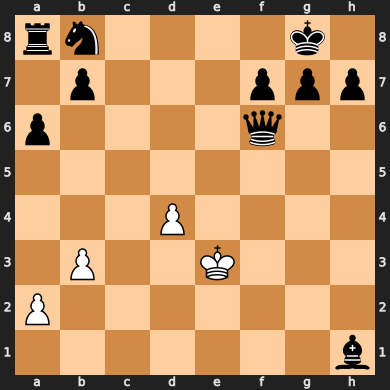

In [56]:
#Look at the board for the final position
fen = game[moves_so_far]['fen']
board = chess.Board(fen)
board

In [57]:
#See what our function produces for this FINAL position
get_eval_top_10(d=game[moves_so_far], moves_so_far=moves_so_far, new_pl_is_white=1, is_final_position=1)

{'eval': {'is_mate_score': 0, 'cp': -3962, 'mate': 0},
 'top10': [{'is_mate_score': 0, 'cp': -4001, 'mate': 0},
  {'is_mate_score': 0, 'cp': -4017, 'mate': 0},
  {'is_mate_score': 0, 'cp': -4028, 'mate': 0},
  {'is_mate_score': 0, 'cp': -4211, 'mate': 0},
  {'is_mate_score': 0, 'cp': -4218, 'mate': 0},
  {'is_mate_score': 0, 'cp': -4221, 'mate': 0},
  {'is_mate_score': 1, 'mate': 23, 'cp': 0},
  {'is_mate_score': 1, 'mate': 23, 'cp': 0},
  {'is_mate_score': 1, 'mate': 23, 'cp': 0},
  {'is_mate_score': 1, 'mate': 23, 'cp': 0}]}

Notice that since this final board position is *not* one where there are no legal moves that can be made (and it is a turn where the new player would normally be asked to make a move), our function *does* return a "top 10 moves".  Since there were fewer than 10 legal moves available, our function duplicated the worst legal move a number of times until we had 10 moves.  Also, since the new player's worst possible move leads to her being checkmated in 7 moves, the score of this move is reported as a 'mate' score of 16 + 7 = 23 (according to the categorical Mate score system mentioned above).

#### A game where the new player is playing Black

In [58]:
game_number = 3333
train_1st.iloc[[game_number]]

,opponent,new_pl_color,new_pl_won,new_pl_elo,opp_elo,new_pl_rating_diff,opp_rating_diff,game_length,time_limit,time_gain_per_move,event,termination,conceded,datetime,timestamp,moves,both_players_1st_game
name_of_pl_playing_1st_game,,,,,,,,,,,,,,,,,
sarazony,giamfede,Black,0.0,1500.0,1526.0,-163.0,7.0,53,900.0,0.0,Classical,Normal,1,2016-07-23 14:00:48,1.469282e+09,d4 d5 e3 e6 Bd3 Nf6 f4 Bb4+ Nc3 O-O Nf3 c6 O-O...,0


This is a game where the new player was playing Black and lost.

In [59]:
game = eval(open(f"{stockfish_paths_dict['train']}/game{game_number}.txt").read())

In [60]:
#Look at the final position for this game that the new player LOST (the new player was
#playing Black)
moves_so_far = len(game)-1
fen = game[moves_so_far]['fen']
game[moves_so_far]

{'fen': '5rk1/p4pp1/4p2p/3p4/3P1P2/4R3/PR4PP/5QK1 b - - 0 27',
 'eval': {'type': 'cp', 'value': 732},
 'top_10': [{'Move': 'g8h7', 'Centipawn': 904, 'Mate': None},
  {'Move': 'a7a5', 'Centipawn': 908, 'Mate': None},
  {'Move': 'f8c8', 'Centipawn': 912, 'Mate': None},
  {'Move': 'a7a6', 'Centipawn': 917, 'Mate': None},
  {'Move': 'h6h5', 'Centipawn': 932, 'Mate': None},
  {'Move': 'e6e5', 'Centipawn': 993, 'Mate': None},
  {'Move': 'g8h8', 'Centipawn': 1001, 'Mate': None},
  {'Move': 'g7g6', 'Centipawn': 1224, 'Mate': None},
  {'Move': 'f8d8', 'Centipawn': 1238, 'Mate': None},
  {'Move': 'f8e8', 'Centipawn': 1527, 'Mate': None}]}

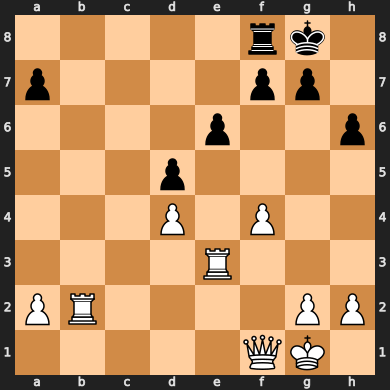

In [61]:
#Look at the final board position (it should be one where legal moves still exist)
board = chess.Board(fen)
board

In [62]:
#Compare to what our function produces: it should invert the signs of the scores
#since our new player is playing Black
get_eval_top_10(d=game[moves_so_far], moves_so_far=moves_so_far, new_pl_is_white=0, is_final_position=1)

{'eval': {'is_mate_score': 0, 'cp': -732, 'mate': 0},
 'top10': [{'is_mate_score': 0, 'cp': -904, 'mate': 0},
  {'is_mate_score': 0, 'cp': -908, 'mate': 0},
  {'is_mate_score': 0, 'cp': -912, 'mate': 0},
  {'is_mate_score': 0, 'cp': -917, 'mate': 0},
  {'is_mate_score': 0, 'cp': -932, 'mate': 0},
  {'is_mate_score': 0, 'cp': -993, 'mate': 0},
  {'is_mate_score': 0, 'cp': -1001, 'mate': 0},
  {'is_mate_score': 0, 'cp': -1224, 'mate': 0},
  {'is_mate_score': 0, 'cp': -1238, 'mate': 0},
  {'is_mate_score': 0, 'cp': -1527, 'mate': 0}]}

#### Another example where the new player is playing Black

In [63]:
game_number = 52
train_1st.iloc[[game_number]]

,opponent,new_pl_color,new_pl_won,new_pl_elo,opp_elo,new_pl_rating_diff,opp_rating_diff,game_length,time_limit,time_gain_per_move,event,termination,conceded,datetime,timestamp,moves,both_players_1st_game
name_of_pl_playing_1st_game,,,,,,,,,,,,,,,,,
intern_slacking,Jmoneyzzz,Black,1.0,1500.0,1410.0,137.0,-29.0,106,180.0,0.0,Blitz,Normal,0,2016-07-12 20:04:10,1.468354e+09,e4 e6 Nf3 d5 exd5 exd5 d4 Bd6 Bd3 Bg4 O-O Ne7 ...,0


This was a game where the new player was playing Black and *won*.

In [64]:
game = eval(open(f"{stockfish_paths_dict['train']}/game{game_number}.txt").read())

In [65]:
#Look at the position 3 moves before the final position (this is a turn when Black moves)
moves_so_far = len(game)-4
fen = game[moves_so_far]['fen']
game[moves_so_far]

{'eval': {'type': 'mate', 'value': -2},
 'top_10': [{'Move': 'd3c2', 'Centipawn': None, 'Mate': -2},
  {'Move': 'd3c3', 'Centipawn': None, 'Mate': -2},
  {'Move': 'd3c4', 'Centipawn': None, 'Mate': -3},
  {'Move': 'g5g4', 'Centipawn': None, 'Mate': -3},
  {'Move': 'a7a6', 'Centipawn': None, 'Mate': -3},
  {'Move': 'b7b6', 'Centipawn': None, 'Mate': -3},
  {'Move': 'a7a5', 'Centipawn': None, 'Mate': -3},
  {'Move': 'c6c5', 'Centipawn': None, 'Mate': -3},
  {'Move': 'b5b4', 'Centipawn': None, 'Mate': -3},
  {'Move': 'b5b6', 'Centipawn': None, 'Mate': -3}],
 'fen': '8/pp5p/2p4p/1q4p1/8/3k4/8/K7 b - - 7 52'}

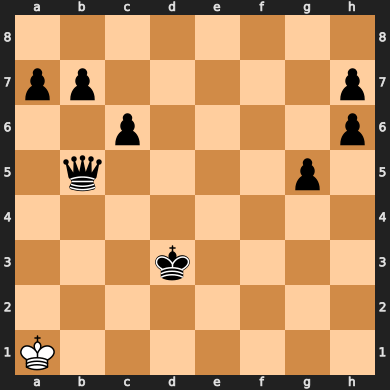

In [66]:
#See what this 4th-from-last position looks like
board = chess.Board(fen)
board

In [67]:
#Compare to what our function produces: it should invert the signs of the scores
#since our new player is playing Black
get_eval_top_10(d=game[moves_so_far], moves_so_far=moves_so_far, new_pl_is_white=0, is_final_position=0)

{'eval': {'is_mate_score': 1, 'mate': 2, 'cp': 0},
 'top10': [{'is_mate_score': 1, 'mate': 2, 'cp': 0},
  {'is_mate_score': 1, 'mate': 2, 'cp': 0},
  {'is_mate_score': 1, 'mate': 3, 'cp': 0},
  {'is_mate_score': 1, 'mate': 3, 'cp': 0},
  {'is_mate_score': 1, 'mate': 3, 'cp': 0},
  {'is_mate_score': 1, 'mate': 3, 'cp': 0},
  {'is_mate_score': 1, 'mate': 3, 'cp': 0},
  {'is_mate_score': 1, 'mate': 3, 'cp': 0},
  {'is_mate_score': 1, 'mate': 3, 'cp': 0},
  {'is_mate_score': 1, 'mate': 3, 'cp': 0}]}

### Using the function to get the scores for *every* position in a single game

Let's return our single example game from before.  We were working with the new player whose game is number 123 in the `train_1st` dataframe:

In [68]:
game_number = 123
kind = 'train'
game = eval(open(f"{stockfish_paths_dict[kind]}/game{game_number}.txt").read())

We found the name of this new player:

In [69]:
new_pl_name

'The_Mechanic_Arg'

We had already recorded lots of information about this player's 1st game, 2nd game, and 2nd-game opponent's previous game.  We entered all this information into our dictionary under this player's name:

In [70]:
example_dict

{'The_Mechanic_Arg': {'data': [0,
   0.0,
   1801.0,
   -71.0,
   4.0,
   70,
   600.0,
   0.0,
   0,
   1,
   0,
   1429.0,
   1435.0,
   600.0,
   0.0,
   0,
   1,
   0.0,
   1445.0,
   1458.0,
   -10.0,
   11.0,
   27,
   600.0,
   0.0,
   0,
   1,
   0,
   0],
  'target': 1.0}}

We need to add the information from all the positions of this new player's first game.  We will store these in a list, under the key '1st_game_positions':

In [71]:
#Initialize a list to store the positions' information
example_dict[new_pl_name]['1st_game_positions'] = []

#Determine if the new player is playing White in this game
new_pl_is_white = dfs_dict[f"{kind}_1st"].iloc[game_number]['new_pl_color']=='White'

In [72]:
moves_so_far = 0

#Add all the non-final positions
for i in range(len(game)-1):
    example_dict[new_pl_name]['1st_game_positions'].append(
        get_eval_top_10(game[moves_so_far], moves_so_far, new_pl_is_white, is_final_position=0)
    )
    #Increment the move counter
    moves_so_far += 1

#Add the final position
moves_so_far = len(game)-1
example_dict[new_pl_name]['1st_game_positions'].append(
        get_eval_top_10(game[moves_so_far], moves_so_far, new_pl_is_white, is_final_position=1)
    )

In [73]:
#See what this looks like
example_dict

{'The_Mechanic_Arg': {'data': [0,
   0.0,
   1801.0,
   -71.0,
   4.0,
   70,
   600.0,
   0.0,
   0,
   1,
   0,
   1429.0,
   1435.0,
   600.0,
   0.0,
   0,
   1,
   0.0,
   1445.0,
   1458.0,
   -10.0,
   11.0,
   27,
   600.0,
   0.0,
   0,
   1,
   0,
   0],
  'target': 1.0,
  '1st_game_positions': [{'eval': {'is_mate_score': 0, 'cp': 64, 'mate': 0},
    'top10': [{'is_mate_score': 0, 'cp': 70, 'mate': 0},
     {'is_mate_score': 0, 'cp': 39, 'mate': 0},
     {'is_mate_score': 0, 'cp': 30, 'mate': 0},
     {'is_mate_score': 0, 'cp': 29, 'mate': 0},
     {'is_mate_score': 0, 'cp': 28, 'mate': 0},
     {'is_mate_score': 0, 'cp': 18, 'mate': 0},
     {'is_mate_score': 0, 'cp': -9, 'mate': 0},
     {'is_mate_score': 0, 'cp': -9, 'mate': 0},
     {'is_mate_score': 0, 'cp': -31, 'mate': 0},
     {'is_mate_score': 0, 'cp': -31, 'mate': 0}]},
   {'eval': {'is_mate_score': 0, 'cp': 23, 'mate': 0}},
   {'eval': {'is_mate_score': 0, 'cp': 56, 'mate': 0},
    'top10': [{'is_mate_score': 0, 'c

## Doing this for *every* new player in the training, test, and validation data

In [76]:
#Loop over the train, test, and validation data kinds
for kind in ['train', 'test', 'val']:
    output_dict = {}
    
    #Loop over the new players, based on their first games
    for game_number in range(len(dfs_dict[f"{kind}_1st"])):
        
        #Get the name of the new player in this row
        new_pl_name = dfs_dict[f"{kind}_1st"].iloc[[game_number]].index[0]
        
        #Add some placeholders to our dictionary for this player
        output_dict[new_pl_name] = {}
        output_dict[new_pl_name]['data'] = []
    
    
    
        #NEW PLAYER'S FIRST GAME
        row = dfs_dict[f"{kind}_1st"].iloc[game_number]

        #Extract the data about the new player's 1st game
        for col in cols_1st:
            #The "termination" column contains a string; convert it to an int
            if col == 'termination':
                output_dict[new_pl_name]['data'].append(termination_dict[row[col]])
            
            #The "new_pl_color" column contains a string; convert it to an int
            elif col == 'new_pl_color':
                output_dict[new_pl_name]['data'].append(color_dict[row[col]])
        
            #Otherwise, just extract the information
            else:
                output_dict[new_pl_name]['data'].append(row[col])
    
        
        
        
        
        #NEW PLAYER'S SECOND GAME
        row = dfs_dict[f"{kind}_2nd"].loc[new_pl_name]

        #Extract the information from the columns we'll use
        for col in cols_2nd:
            output_dict[new_pl_name]['data'].append(row[col])
    
        #Extract the target variable as well
        output_dict[new_pl_name]['target'] = row['new_pl_won']
        
        
        
        
        #NEW PLAYER'S 2ND-GAME OPPONENT'S PREVIOUS GAME
        row = dfs_dict[f"{kind}_opp"].loc[new_pl_name]

        #If the new player's 2nd-game opponent had no previous game, use the default values
        if row['2nd_game_opp_had_no_previous_game'] == 1:
            for col in cols_opp:
                output_dict[new_pl_name]['data'].append(opp_defaults[col])

        #Otherwise, extract the information from the dataframe
        else:
            for col in cols_opp:
                #The "termination" column contains a string; convert it to an int
                if col == 'termination':
                    output_dict[new_pl_name]['data'].append(termination_dict[row[col]])
        
                #The "new_pl_color" column contains a string; convert it to an int
                elif col == 'opp_color':
                    output_dict[new_pl_name]['data'].append(color_dict[row[col]])
        
                #Otherwise, just extract the information
                else:
                    output_dict[new_pl_name]['data'].append(row[col])
    
    
    
    
        #NEW PLAYER'S FIRST GAME: POSITION EVALUATIONS
        game = eval(open(f"{stockfish_paths_dict[kind]}/game{game_number}.txt").read())
    
        #Initialize a list to store the positions' information
        output_dict[new_pl_name]['1st_game_positions'] = []

        #Determine if the new player is playing White in this game
        new_pl_is_white = dfs_dict[f"{kind}_1st"].iloc[game_number]['new_pl_color']=='White'
    
        #Count how many moves have been made so far
        moves_so_far = 0

        #Add all the non-final positions
        for i in range(len(game)-1):
            output_dict[new_pl_name]['1st_game_positions'].append(
                get_eval_top_10(game[moves_so_far], moves_so_far, new_pl_is_white, is_final_position=0)
            )
            #Increment the move counter
            moves_so_far += 1

        #Add the final position
        moves_so_far = len(game)-1
        output_dict[new_pl_name]['1st_game_positions'].append(
                get_eval_top_10(game[moves_so_far], moves_so_far, new_pl_is_white, is_final_position=1)
            )
    
    #Write the outputted dictionary for this train, test, or val data as one file
    open(f"../data/sf_evals/{kind}.txt", 'w+').write(str(output_dict))
    
    #Also save a pickled file (more efficient for loading into memory)
    pickle.dump(output_dict, open(f"../data/sf_evals/{kind}.pcl", "wb"))

# What's Next?

In the [next notebook](./04_baseline_models.ipynb), we create our baseline models.